# DETECTION AND DATA EXTRACTION FROM CREDIT CARD OBJECT

[![Grounding DINO](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO)
[![GLIGEN](https://badges.aleen42.com/src/github.svg)](https://github.com/gligen/GLIGEN)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb)


[![Nahuel Tabasso](https://badges.aleen42.com/src/instagram.svg)](https://www.instagram.com/nahuel.tabasso?igsh=MTBrbnp0MGlqdGc3aA%3D%3D&utm_source=qr)

[![Visual Studio Code](https://badges.aleen42.com/src/visual_studio_code.svg)](https://www.python.org/)
[![Python](https://badges.aleen42.com/src/python.svg)](https://www.python.org/)
[![PyTorch](https://img.shields.io/badge/PyTorch-EE4C2C?style=flat-square&logo=pytorch&logoColor=white)](https://pytorch.org/)
[![Docker](https://badges.aleen42.com/src/docker.svg)](https://www.python.org/)


In this notebook, we are develop a process to detect credit cards from images delivered by user used to GroundingDino and extract the data through OCR from credit card object. So, this notebook shows the necessaries steps to set up your environment, load, detect credit card and info extract from it.

# BUILT ENVIRONMENT

In this step you have two option, if you prefer you can build and run the docker image with the follows command

```bash
docker-compose build
```

After built the docker image, run container with the next command
```bash
docker-compose up -d
```

If you prefer build your own local environment follow the next steps:

##### Step 1 - Create a python envinroment

In [ ]:
! python -m pip install pipenv
! python -m pipenv shell

##### Step 2 - Download the requires libraries from requirements.txt and install GroundingDino

In [ ]:
! pip install -r requirements.txt
! pipenv run pip install git+https://github.com/IDEA-Research/GroundingDINO.git@df5b48a3efbaa64288d8d0ad09b748ac86f22671

##### Step 3 - Download GroundingDino Weights

In [ ]:
! mkdir weights
! cd weights
! ! wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

## IMPORT LIBRARIES

In [464]:
from groundingdino.util.inference import Model
from abc import ABC, abstractmethod
import cv2
import os
import torch
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import easyocr
import re

## FIRST STEP - LOAD THE IMAGE

In the first place, load the image that use as example to work in this notebook.

**IMPORTANT**

**Keep in mind this credit card is not a real card, it is just a test card downloaded from the internet only for the purposes of this notebook**

In [506]:
IMAGE_PATH = "../../data/input_data/credit-card-10.png"

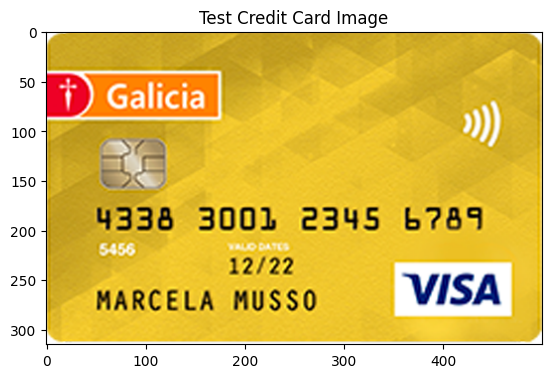

In [507]:
img = cv2.imread(filename=IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show test image
plt.imshow(img_rgb)
plt.title("Test Credit Card Image")
plt.show()

## SECOND STEP - LOAD MODEL

In this step, load the GroundingDino model to made inferences in the nexts steps with the test images

First, need to define if the inference will run in **"cpu"** or in **"gpu"**, for this it depends of the machine. To run in gpu need a graphics video card
preferently NVidia. If not have a video card, run the inference in cpu.

To set in our model instance the way in what must to running the inference, valid the **"cuda"** status with **PyTorch** in a new variable to set then in our model.

In [472]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Define the needs paths to load the model

In [473]:
MODEL_CONFIG_PATH = "../config/GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "../../weights/groundingdino_swint_ogc.pth"

Now, instance the GroundingDino Model

In [474]:
model = Model(model_config_path=MODEL_CONFIG_PATH,
              model_checkpoint_path=WEIGHTS_PATH,
              device=device)

model

final text_encoder_type: bert-base-uncased


## THIRD STEP - MAKE INFERENCE OVER A TEST IMAGE

Now, in this step before to make the inference, need to define a threslhods as `BOX_THRESHOLD` and  `TEXT_THRESHOLD` along the prompt of what you want to detect 
in the image.

In [508]:
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
TEXT_PROMPT = ["credit card"]

detections = model.predict_with_classes(image=img,
                                        classes=TEXT_PROMPT,
                                        box_threshold=BOX_THRESHOLD,
                                        text_threshold=TEXT_THRESHOLD)
detections

Detections(xyxy=array([[1.5548706e-02, 2.1656799e-01, 4.9995892e+02, 3.1285004e+02]],
      dtype=float32), mask=None, confidence=array([0.84605896], dtype=float32), class_id=array([0]), tracker_id=None, data={})

Show the image with the bounding box of detections

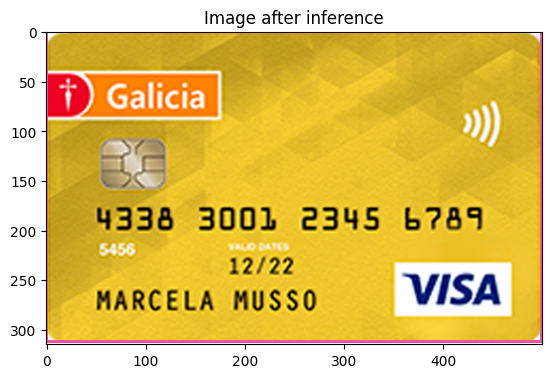

In [509]:
box_annotator = sv.BoundingBoxAnnotator()
annotated_image = box_annotator.annotate(scene=img_rgb,
                                         detections=detections)

plt.imshow(annotated_image)
plt.title("Image after inference")
plt.show()

## FOUR STEP - CUT OUT THE CREDIT CARD FROM THE IMAGE

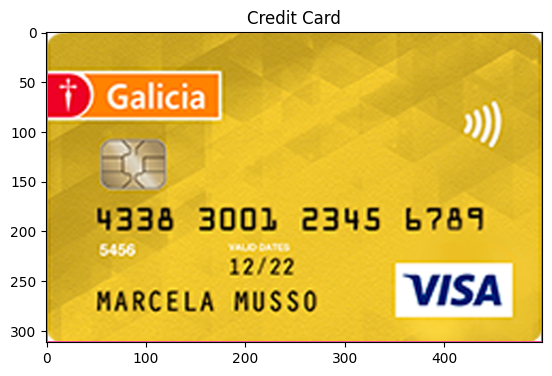

In [510]:
# Validate if the model detected only one credit card, else the image is not valid
xyxy = detections.xyxy
if len(xyxy) == 1:
    # Cast to int the coordinates
    xyxy = [int(coord) for coord in xyxy[0]]
    
    credit_card = img_rgb[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
    plt.imshow(credit_card)
    plt.title("Credit Card")
    plt.show()
else: 
    print("Image not valid!")

## FIVE STEP - SHOW RESULTS

Show the results, now we are showing the original image, annotated imagen and the cut of credit card

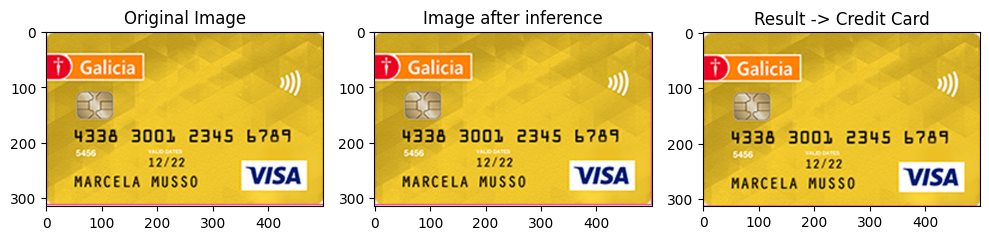

In [511]:
images = [img_rgb, annotated_image, credit_card]
labels = ["Original Image", "Image after inference", "Result -> Credit Card"]

# Create subplots
fig, ax = plt.subplots(1, len(images), figsize=(10, 5))

for index, img in enumerate(images):
    # Show each image in subplot
    ax[index].imshow(img)
    ax[index].set_title(labels[index])
    
    fig.tight_layout()

plt.show()

## ENDS THE FIRST STAGE

With this, it ends the first stage of this process with the cutting of the credit card by GroundingDino model, which it is a AI model used to object segmentation
and detections in images by a specific prompt.

# SECOND STAGE

In this stage, it tries to define which type of credit card is our card (VISA, MasterCard, American Express, Cabal) throuhg SIFT Algorithm to determinate this characteristic in our bussiness

## FIRST STEP - LOAD AND SHOW PATTERNS KIND OF CARDS

['../../data/patterns/visa1.jpg', '../../data/patterns/visa2.jpg', '../../data/patterns/american-express.png', '../../data/patterns/cabal.jpg', '../../data/patterns/american-express1.png', '../../data/patterns/mastercard.png', '../../data/patterns/mastercard1.jpeg']


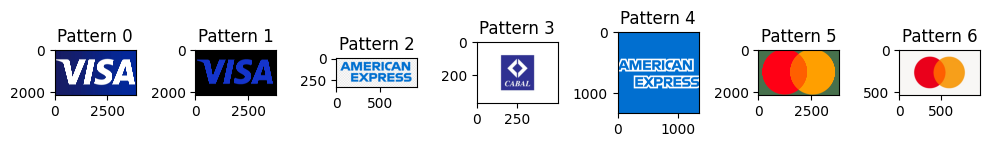

In [479]:
BASE_PATTERNS_DIR = "../../data/patterns"

patterns = os.listdir(BASE_PATTERNS_DIR)
patterns = [os.path.join(BASE_PATTERNS_DIR, p) for p in patterns]
print(patterns)

# Define a dictionary with the paths of patterns
PATTERNS_DICT = {
    "visa": '../../data/patterns/visa1.jpg',
    "visa_aux": '../../data/patterns/visa2.jpg',
    "american_express": '../../data/patterns/american-express1.png',
    "cabal": '../../data/patterns/cabal.jpg',
    "mastercard": '../../data/patterns/mastercard1.jpeg'
}

# Create subplots
fig, ax = plt.subplots(1, len(patterns), figsize=(10, 5))

for index, pattern in enumerate(patterns):
    # Load pattern
    img = cv2.imread(filename=pattern)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Show each image in subplot
    ax[index].imshow(img)
    ax[index].set_title(f"Pattern {index}")
    
    fig.tight_layout()

plt.show()

## SECOND STEP - DEFINE ROIs FOR CREDIT CARD

In this point, it needs to define and regions or zones of interest in our credit card, for example: zone of credit card type, zone of number, zone of expiration date.

In [480]:
def to_fixed(img: np.ndarray, bbox: tuple) -> tuple:
    """This method convert relatives coords from a bbox to
    absolutes coords

    Args:
        img (np.ndarray): _description_
        bbox (tuple): _description_

    Returns:
        tuple: _description_
    """    
    if len(img.shape) == 3:
        h, w, _ = img.shape
    elif len(img.shape) == 2:
        h, w = img.shape

    relative_bbox = [ (int(b[0]*w), int(b[1]*h)) for b in bbox ]

    return relative_bbox 

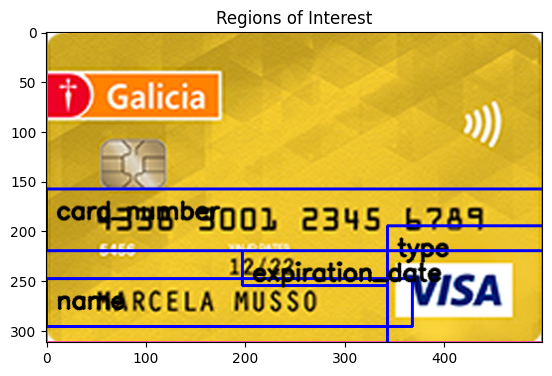

In [512]:
# Generate a copy to show ROIs in this example
credit_card_ann = credit_card.copy()

# ROIs in this example
VISA_CREDIT_CARD_ZONES = {
    "type": [(0.6889763779527559, 0.6269592476489029), (1.0826771653543308, 1.4106583072100314)],
    "card_number": [(0.0, 0.50858934169279), (1.0826771653543308, 0.7053291536050157)],
    "name": [(0.0, 0.7950470219435737), (0.7381889763779528, 0.9504388714733543)],
    "expiration_date": [(0.3952755905511811, 0.7053291536050157), (0.6889763779527559, 0.8175862068965517)]
}

for zone_name, coords in VISA_CREDIT_CARD_ZONES.items():
    p1, p2 = to_fixed(credit_card_ann, coords)
    credit_card_ann = cv2.rectangle(img=credit_card_ann,
                                    pt1=p1,
                                    pt2=p2,
                                    color=(0, 0, 255),
                                    thickness=2)

    # Fix the text position into a rectangle
    text_position = (p1[0] + 10, p1[1] + 30)  # Ajustar según sea necesario

    # Write the zone name with OpenCV
    credit_card_ann = cv2.putText(img=credit_card_ann,
                                  text=zone_name,
                                  org=text_position,
                                  fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                  fontScale=0.8,
                                  color=(0, 0, 0),
                                  thickness=2,
                                  lineType=cv2.LINE_AA)

plt.imshow(credit_card_ann)
plt.title("Regions of Interest")
plt.show()

## THIRD STEP - PATTERN MATCHING

In this part, define the **Payment Network** of the card that we are processing in this notebook using the **Pattern Matching** technique
using the **SIFT** algorithm.

To this, first declare an abstract class ObjectDetector and a subclass SIFTObjectDetector that inherit from it. Then apply a pattern matching over credit card

In [482]:
class ObjectDetector(ABC):
    @abstractmethod
    def set_target_image(self, image_path):
        pass
    @abstractmethod
    def load_reference_images(self, image_paths):
        pass
    @abstractmethod
    def detect(self):
        pass

class SIFTObjectDetector(ObjectDetector):
    def __init__(self, match_threshold=20, lowe_ratio=0.7):
        self.sift = cv2.SIFT_create()
        self.target_image = None
        self.target_kp = None
        self.target_des = None
        self.reference_images = {}
        self.match_threshold = match_threshold
        self.lowe_ratio = lowe_ratio

    def preprocess_image(self, image):
        # Convert to grayscale if it's not already
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        # Apply histogram equalization
        # equalized = cv2.equalizeHist(gray)
        # # Apply Gaussian blur
        # blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
        # return blurred
        return gray

    def set_target_image(self, image):
        self.target_image = self.preprocess_image(image)
        self.target_kp, self.target_des = self.sift.detectAndCompute(self.target_image, None)

    def load_reference_images(self, image_paths):
        for name, path in image_paths.items():
            image = cv2.imread(path)
            processed_image = self.preprocess_image(image)
            kp, des = self.sift.detectAndCompute(processed_image, None)
            self.reference_images[name] = {'image': processed_image, 'kp': kp, 'des': des, 'original': image}

    def detect(self):
        if self.target_image is None or not self.reference_images:
            raise ValueError("Target image and reference images must be loaded before detection")
        
        best_match = None
        max_good_matches = 0
        
        for name, ref in self.reference_images.items():
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(ref['des'], self.target_des, k=2)
            
            good_matches = []
            for m, n in matches:
                if m.distance < self.lowe_ratio * n.distance:
                    good_matches.append(m)
            
            print(f"{name}: {len(good_matches)} good matches")
            
            if len(good_matches) > max_good_matches:
                max_good_matches = len(good_matches)
                best_match = name

        # Verificar si el mejor match supera el umbral
        if max_good_matches >= self.match_threshold:
            return best_match
        return None

    def check_color(self, image, colors, threshold=1000):
        for color in colors:
            mask = cv2.inRange(image, np.array(color) - 30, np.array(color) + 30)
            if cv2.countNonZero(mask) > threshold:
                return True
        return False

Now, define a method to extract and speficif zone from a credit card

In [483]:
def extract_zone(img: np.ndarray, zone: list) -> np.ndarray:
    """Cuts out a zone (bbox) and returns it

    Args:
        img (np.ndarray): opencv image
        zone (list): bbox in format [(x1, y1), (x2, y2)]

    Returns:
        np.ndarray: zone cutted from the image
    """
    p1, p2 = to_fixed(img, zone)
    return img[p1[1]:p2[1], p1[0]:p2[0], ...]

Try the Pattern Matching to define the payment network of our card

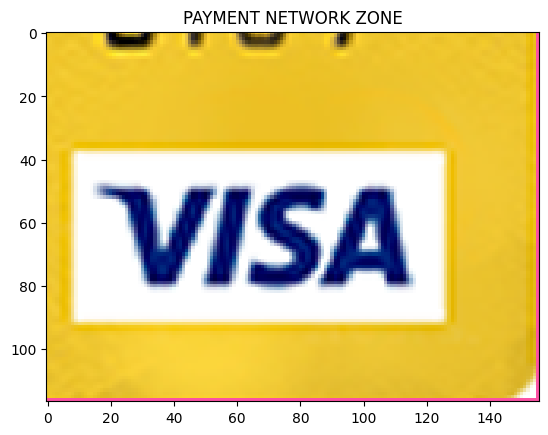

In [484]:
# Extract the type zone
zone = extract_zone(credit_card, VISA_CREDIT_CARD_ZONES['type'])

plt.imshow(zone)
plt.title("PAYMENT NETWORK ZONE")
plt.show()

In [485]:
# Create a new instance of SIFT
detector = SIFTObjectDetector(match_threshold=20, lowe_ratio=0.7)
# Set a target image to detector
detector.set_target_image(zone)
# Load reference images
detector.load_reference_images(PATTERNS_DICT)
# Make the matching
result = detector.detect()

type = ""
if result != None:
    if result.startswith("visa"):
        type = "VISA"
    elif result.startswith("american_"):
        type = "AMERICAN EXPRESS"
    elif result.startswith("cabal"):
        type = "CABAL"
    elif result.startswith("mastercard"):
        type = "MASTERCARD"
else:
    type = None

print(f"\n\nPayment Network of credit card is {type}")

visa: 864 good matches
visa_aux: 255 good matches
american_express: 11 good matches
cabal: 2 good matches
mastercard: 20 good matches


Payment Network of credit card is VISA


## ENDS THE SECOND STAGE

The payment network was defined with the use of the SIFT algorithm, this method is not completely reliable because the credit cards have different colors and shapes of the payment network logo, which is why it is necessary to obtain high quality patterns and definition of these networks.

Therefore, to validate this later, it is advisable to use the IIN (Issuer Identification Number) method, which consists of validating the numbers according
to the patterns of each payment entity

## THIRD STAGE

In this stage, extract the data from credit card by its Payment Network obtained in the previous stage. To do this use an OCR technique to read the text on a credit card image,
There are different libraries to do the OCR technique some of them processing in the clooud (e.g **Google Cloud Vision** or **Amazon Textract**) but these libraries aren't free, you need
an account and a suscription to get a API_KEY from Google or Amazon. Other than that is not convinient process sensible data in the cloud by security reasons. However exists some libraries
that processing locally (e.g **EasyOCR** or **Tesseract**), in some cases the precision of those packages may be somewhat lower than Google library, but you can more control about your service.

In this notebook for this third stage, we use a library called **EasyOCR**, which it is a **Python** library that use deep learning techniques to do OCR.
* To increase the precision of OCR, make a pre-process on image previous to make OCR

## FIRST STEP - PRE-PROCESS OF CREDIT CARD IMAGE

In this step, make a pre-process of credit card image.

Apply the follows transformations:
* Convert image to gray scale image
* Increase the constrast

In [486]:
def preprocess_img(image: np.ndarray, save: bool = False):
    """This function make a pre-process on image: convert to gray scale and 
    increase the contrast and brightness.
    
    Make the follows steps to its pre-process:
    1. Verify that input image be valid
    2. Convert input image to a gray scale
    3. Increase image contrast
    4. Save images to visual inspection

    Args:
        image (np.ndarray): Input image in numpy array format.

    Raises:
        FileNotFoundError: _description_

    Returns:
        _type_: output image in numpy array format
    """
    if image is None:
        raise FileNotFoundError("Imagen no valida")
    
    # Convert img to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if save:
        cv2.imwrite("./gray.jpg", gray)
    # Increase constrast and brightness
    contrast = 1.5
    bright = 0
    enhanced = cv2.addWeighted(gray, contrast, gray, 0, bright)

    # Make sure the values are in the range [0, 255]
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)
    if save:
        cv2.imwrite("./enhanced.jpg", enhanced)
    return enhanced

**Is recommended to apply a pre-processing on image before to pass by the OCR technique**

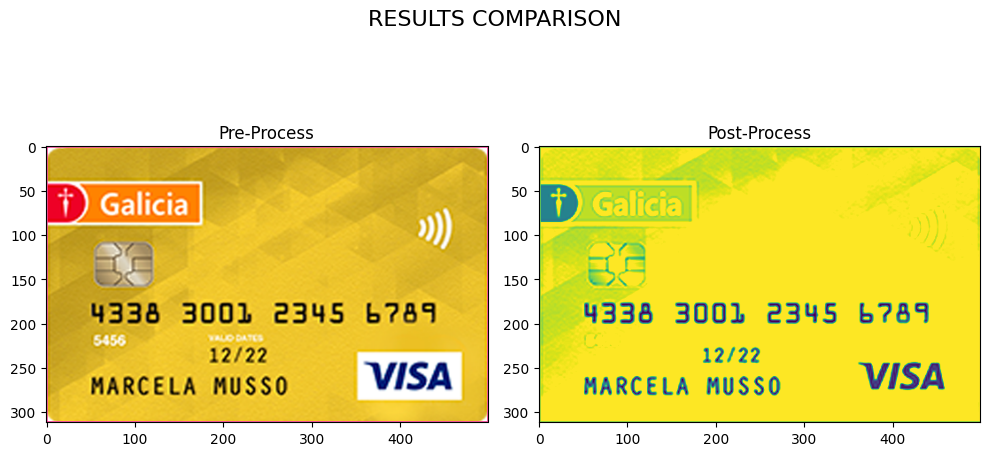

In [487]:
credit_card_procces = preprocess_img(image=credit_card, save=True)

images = [credit_card, credit_card_procces]
labels = ["Pre-Process", "Post-Process"]
# SHOW RESULTS
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for index, img in enumerate(images):
    # Show each image in subplot
    ax[index].imshow(img)
    ax[index].set_title(labels[index])
    
    fig.tight_layout()

fig.suptitle("RESULTS COMPARISON", fontsize=16, y=1.05)
plt.show()

## SECOND STEP - EXTRACT DATA FROM CREDIT CARD

Here, try to extract data from credit card through a OCR technique using EasyOCR

* First, try to extract the number of credit card

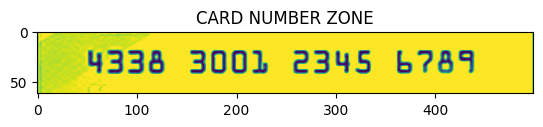

In [488]:
number_zone = extract_zone(img=credit_card_procces,
                           zone=VISA_CREDIT_CARD_ZONES['card_number'])
plt.imshow(number_zone)
plt.title("CARD NUMBER ZONE")
plt.show()

Apply the OCR technique to a number_zone image

In [489]:
# Create an easyocr instance
reader = easyocr.Reader(['en'])
# Make OCR
results = reader.readtext(number_zone)

print(results)
card_number = ""
for (bbox, text, prob) in results:
    card_number += text     

print(f"CARD NUMBER AFTER OCR --- {card_number}")

[([[45, 13], [135, 13], [135, 49], [45, 49]], '4338', 0.9997789263725281), ([[149, 13], [237, 13], [237, 49], [149, 49]], '3001', 0.9818680286407471), ([[253, 13], [343, 13], [343, 49], [253, 49]], '2345', 0.9999918341636658), ([[356, 12], [447, 12], [447, 50], [356, 50]], '6789', 0.7128134965896606)]
CARD NUMBER AFTER OCR --- 4338300123456789


* Try to extract a name from credit card

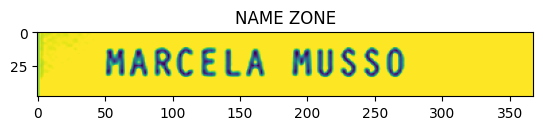

[([[48, 8], [174, 8], [174, 40], [48, 40]], 'MARCELA', 0.8646706281769857), ([[186, 8], [278, 8], [278, 40], [186, 40]], 'Musso', 0.34293903033962425)]
NAME AFTER OCR --- MARCELA MUSSO 


In [495]:
name_zone = extract_zone(img=credit_card_procces,
                         zone=VISA_CREDIT_CARD_ZONES['name'])
plt.imshow(name_zone)
plt.title("NAME ZONE")
plt.show()

# Make OCR
results = reader.readtext(name_zone)

print(results)
name = ""
for (bbox, text, prob) in results:
    name += text + " "     

name = name.upper()
print(f"NAME AFTER OCR --- {name}")

* Try to extract the expiration date from credit card

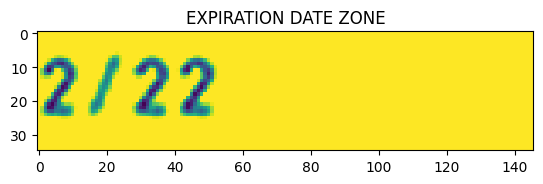

[([[0, 4], [56, 4], [56, 30], [0, 30]], '2/22', 0.6922153588105392)]
EXPIRATION DATE AFTER OCR --- 2/22


In [497]:
exp_date_zone = extract_zone(img=credit_card_procces,
                         zone=VISA_CREDIT_CARD_ZONES['expiration_date'])
plt.imshow(exp_date_zone)
plt.title("EXPIRATION DATE ZONE")
plt.show()

# Make OCR
results = reader.readtext(exp_date_zone)

print(results)
expiration_date = ""
pattern = r'^[0-9/]+$'

for (bbox, text, prob) in results:
    if re.match(pattern, text):
        expiration_date += text     

print(f"EXPIRATION DATE AFTER OCR --- {expiration_date}")

## THIRD STEP - SHOW DATA

Show the results

In [496]:
print(f"PAYMENT NETWORK --- {type}")
print(f"CARD NUMBER --- {card_number}")
print(f"NAME --- {name}")
print(f"EXPIRATION DATE --- {expiration_date}")

PAYMENT NETWORK --- VISA
CARD NUMBER --- 4338300123456789
NAME --- MARCELA MUSSO 
EXPIRATION DATE --- 2/22


# END

With this, the process of this service ends, representing in a Jupyter Notebook with visual purposes of explaining step by step the method
to detect a credit card with GroundingDINO, then determine the Payment Network and finally extract the card information through OCR application.


#### NOTES
* To test this service using a dynamic graphical process, run in a terminal the follow command:
```bash
python gradio_ui_app.py
```

This command will set up a Gradio server and return the url to be able to access the Gradio Interface and be able to use the app.

* To test this service through API in /src/api/ the follow command:
```bash
python main.py
```

This command will set up a server. After this, you can access to http://localhost:8000/docs to enter in Swagger and test the different APIs